In [36]:

import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

foot_path = "../draw_model_result/"

In [ ]:
with open(foot_path+'all_test_dict.json', 'r') as f:
    all_test_dict = json.load(f)

all_user_session_immers={}
for user in all_test_dict:
    len(all_test_dict[user])
    all_user_session_immers[user]={}
    for session in all_test_dict[user]:
        df = pd.DataFrame(all_test_dict[user][session])
        curve = df['immersion'].tolist()
        all_user_session_immers[user][session]=curve

with open(foot_path+'all_user_session_immers.json','w') as f:
        json.dump(all_user_session_immers,f)

In [ ]:
with open(foot_path+'all_user_session_immers.json','r') as f:
    all_user_session_immers = json.load(f)

In [ ]:
from scipy.interpolate import interp1d
def linear_interpolation(data, n):
    x = np.arange(len(data))
    f = interp1d(x, data)
    x_new = np.linspace(0, len(data)-1, n)
    return f(x_new)

# def segment_filter(data, window_size, step_size):
#     smoothed_data = []
#     num_segments = (len(data) - window_size) // step_size + 1

#     for i in range(num_segments):
#         segment = data[i*step_size : i*step_size + window_size]
#         segment_mean = np.mean(segment)
#         smoothed_data.extend([segment_mean] * window_size)

#     return smoothed_data
all_user_session_immers_inter={}
N=1000
count_all, count_valid = 0, 0
for user in all_user_session_immers:
    all_user_session_immers_inter[user]=[]
    for session in all_user_session_immers[user]:
        y_list= all_user_session_immers[user][session]
        count_all+=1
        if len(y_list)<10:
            continue
        same_y= linear_interpolation(y_list, N)
        all_user_session_immers_inter[user].append(same_y)
        
        count_valid+=1
print(count_all,count_valid)

802841 42392


In [ ]:
from sklearn.cluster import KMeans
y_all = []
for user in all_user_session_immers_inter:
    y_all.extend([list(seq) for seq in all_user_session_immers_inter[user]])
X = np.array(y_all)
print(X.shape)
X = X[np.random.choice(X.shape[0], 1000, replace=False),:]
print(X.shape)

print(np.where(np.isnan(X)))


(42392, 1000)
(1000, 1000)
(array([], dtype=int64), array([], dtype=int64))


In [ ]:
import numpy as np
y_all = []
for user in all_user_session_immers_inter:
    y_all.extend([list(seq) for seq in all_user_session_immers_inter[user]])
X = np.array(y_all)
print(X.shape)

num_segments = 4
segment_width = X.shape[1] // num_segments
print(segment_width)
segment_means = np.zeros((X.shape[0],num_segments))
for i in range(num_segments):
    segment_means[:,i] = np.mean(X[:, i*segment_width: i*segment_width+segment_width], axis=1)
print(segment_means.shape)
print(np.where(np.isnan(segment_means)))

segment_mean_diffs = np.zeros((X.shape[0],6))
count=0
for i in range(num_segments):
    for j in range(num_segments):
        if i<=j:
            continue
        segment_mean_diffs[:,count] = segment_means[:,i] - segment_means[:,j]
        count+=1
print(segment_mean_diffs.shape)

result_matrix = np.column_stack((segment_means, segment_mean_diffs))

print(result_matrix.shape)
print(np.where(np.isnan(result_matrix)))

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=10, 
                random_state=0)
y_pred = kmeans.fit_predict(result_matrix)

(5899, 1000)
5899
(5152, 1000)
5152
(4329, 1000)
4329
(27012, 1000)
27012


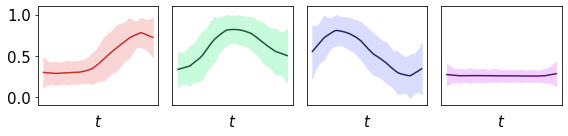

In [68]:
# min_val = np.min(X, axis=0)
# max_val = np.max(X, axis=0)
# X_nor = (X - min_val) / (max_val - min_val)
# print(X)

plt.figure(figsize=(8,2))
avg_list, se_list =[],[]
min_all=10
max_all=-10
colors=[["#c72e29","#F9D6D5"],['#185831','#C8FADC'],['#202765','#D9DCFD'],['#5B1176','#F2D0FF']]
cluster_list=[2,3,0,1]
for cluster_label in cluster_list:
    cluster_indices = np.where(y_pred == cluster_label)[0]
    y_array = X[cluster_indices]
    print(y_array.shape)
    
    print(len(cluster_indices))
    avg = np.mean(y_array, axis=0)
    
    se = np.std(y_array, axis=0)
    se_list.append(se)
    avg_list.append(avg)
    min = np.min(avg-se)
    max = np.max(avg+se)
    if min<min_all:
        min_all=min
    if max>max_all:
        max_all=max

for cluster_label in cluster_list:
    avg = avg_list[cluster_label]
    se = se_list[cluster_label]
    down_line = (avg-se - min_all)/(max_all - min_all)
    up_line = (avg+se - min_all)/(max_all - min_all)
    avg =  (avg - min_all)/(max_all - min_all)
    se = se/(max_all-min_all)
    # min = np.min(avg-se)
    # max= np.max(avg+se)
    # avg-
    
    plt.subplot(1, n_clusters, cluster_label+1)
             
    x = np.arange(N)
    plt.plot(x, avg,color=colors[cluster_label][0])
    plt.fill_between(x, avg - se, avg + se,color=colors[cluster_label][1])
    # plt.show()
    
    x_new=[]
    for i in range(N):
        x_new.append(x[i]/100)
    plt.xticks([])
    plt.xlabel('$t$',fontsize=15)
    plt.ylim(-0.1,1.1)
    plt.yticks([0, 0.5, 1],fontsize=15)
    if cluster_label !=0:
        plt.yticks([])
    # if cluster_label==1:
    #     print(np.min(avg-se),np.max(avg+se))
    

    # plt.legend()
plt.tight_layout()
plt.savefig('immersion_curve.pdf')
plt.show()


In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

y_all = []
for user in all_user_session_immers_inter:
    y_all.extend([list(seq) for seq in all_user_session_immers_inter[user]])

X = np.array(y_all)
print(X.shape)
X = X[np.random.choice(X.shape[0], 100, replace=False),:]
print(X.shape)

def dtw_distance(x, y):
    n, m = len(x), len(y)
    dp = np.zeros((n+1, m+1))

    for i in range(1, n+1):
        dp[i, 0] = float('inf')
    for j in range(1, m+1):
        dp[0, j] = float('inf')

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(x[i-1] - y[j-1])
            dp[i, j] = cost + min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1])

    return dp[n, m]

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, 
                random_state=0)

distances = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(i+1, len(X)):
        distances[i, j] = dtw_distance(X[i], X[j])
        distances[j, i] = distances[i, j]

y_pred = kmeans.fit_predict(distances)

for cluster_label in range(n_clusters):
    plt.figure()
    cluster_indices = np.where(y_pred == cluster_label)[0]
    for idx in cluster_indices:
        plt.plot(X[idx].ravel(), "k-", alpha=0.7)
    plt.title(f'Cluster {cluster_label}')
    plt.show()